In [234]:
!pwd

/Users/naveed/projects/machine-learning-zoomcamp/cohorts/2023


In [235]:
!ls

01-intro      README.md     data.csv.1    data.csv.3    hw1.ipynb
02-regression data.csv      data.csv.2    housing.csv   hw4.ipynb


In [236]:
!wget wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-09 09:33:00--  http://wget/
Resolving wget (wget)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘wget’
--2023-10-09 09:33:00--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv.4’

data.csv.4          100%[===================>]   1.41M  5.17MB/s    in 0.3s    

2023-10-09 09:33:01 (5.17 MB/s) - ‘data.csv.4’ saved [1475504/1475504]

FINISHED --2023-10-09 09:33:01--
Total wall clock time: 1.0s
Downloaded: 1 files, 1.4M in 0.3s (5.17 MB/s)


In [237]:
import pandas as pd

In [238]:
df = pd.read_csv("data.csv.1")

In [239]:
df.columns

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')

In [240]:
columns = ["Make",
"Model",
"Year",
"Engine HP",
"Engine Cylinders",
"Transmission Type",
"Vehicle Style",
"highway MPG",
"city mpg",
"MSRP"]

In [241]:
df = df[columns]

In [242]:
df.rename(mapper=str.lower, axis=1, inplace=True)

In [243]:
df.columns = df.columns.str.replace(" ", "_")

In [244]:
df.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'msrp'],
      dtype='object')

In [245]:
df.fillna(0, inplace=True)

In [246]:
df["above_average"] = (df["msrp"] > df["msrp"].mean()).astype(int)
del df["msrp"]

In [247]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score

In [248]:
df_fulltrain, df_test = train_test_split(df, test_size=.2, random_state=1)
df_train, df_val = train_test_split(df_fulltrain, test_size=.25, random_state=1)

In [249]:
numerical = ["year", "engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]
categorical = ["make", "model", "transmission_type", "vehicle_style"]

In [250]:
df_train.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
above_average          int64
dtype: object

In [251]:
for n in numerical[1:]: 
    temp_df = df_train.sort_values(by=n)
    temp_df[f"{n}_normalized"] = temp_df[n] / temp_df[n].max()
    #print (temp_df[f"{n}_normalized"])
    print(n, auc(temp_df[f"{n}_normalized"], temp_df["above_average"]))

engine_hp 0.683316683316683
engine_cylinders 0.625
highway_mpg 0.809322033898305
city_mpg 0.36131386861313874


In [252]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

In [253]:

df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [254]:
# del df_train["msrp"]
# del df_val["msrp"]
# del df_test["msrp"]
del df_train["above_average"]
del df_val["above_average"]
del df_test["above_average"]

In [255]:
dv = DictVectorizer(sparse=False)

In [256]:
train_dict = df_train.to_dict(orient="records")

In [257]:
X_train = dv.fit_transform(train_dict)

In [258]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [259]:
val_dict = df_val.to_dict(orient="records")
X_val = dv.transform(val_dict)

In [260]:
y_pred = model.predict_proba(X_val, )[:, 1]

In [261]:
y_pred

array([0.59041254, 0.02351996, 0.57776302, ..., 0.00627176, 0.9999908 ,
       0.07880016])

In [262]:
churn_decision = (y_pred >= .5)

In [263]:
(churn_decision == y_val).mean()

0.9244649601342845

In [264]:
from sklearn.metrics import accuracy_score, roc_curve

In [265]:
accuracy_score(y_val, churn_decision)

0.9244649601342845

In [266]:
fpr, tpr, threshholds = roc_curve(y_val, y_pred)

In [267]:
import matplotlib.pyplot as plt
import numpy as np

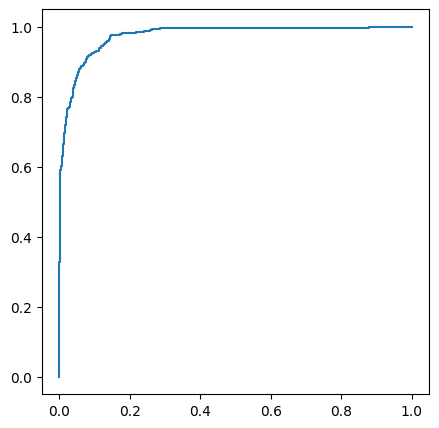

In [268]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label="Model")

In [269]:
auc(fpr, tpr)

0.9748126491245758

In [270]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [271]:
thresholds = np.linspace(0, 1, 101)

In [272]:
for t in thresholds: 
    churn_decision = (y_pred >= t)
    p = precision_score(y_val, churn_decision )
    r = recall_score(y_val, churn_decision )
    f = f1_score(y_val, churn_decision)
    #print(t, p, r, f)
    

/Users/naveed/miniconda3/envs/mlz1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [288]:
def train(df_train, y_train, c):
    dicts = df_train.to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

    

In [274]:
dv, model = train(df_train, y_train)

In [275]:
df_val.dtypes

index                  int64
make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
dtype: object

In [276]:
def predict(df, dv, model):
    dicts = df.to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred
    

In [277]:
predict(df_val, dv, model)

array([0.59041254, 0.02351996, 0.57776302, ..., 0.00627176, 0.9999908 ,
       0.07880016])

In [278]:
from sklearn.model_selection import KFold

In [279]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)


In [280]:
next(kfold.split(df_fulltrain))

(array([   0,    1,    2, ..., 9528, 9529, 9530]),
 array([   6,    7,   21, ..., 9520, 9525, 9527]))

In [281]:
!pip install tqdm 
from tqdm.auto import tqdm

In [283]:
df_fulltrain.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
above_average          int64
dtype: object

In [292]:
scores = [] 

LogisticRegression(solver='liblinear', C=C, max_iter=1000)
for c in C: 
    for train_idx, val_idx in tqdm(kfold.split(df_fulltrain)):
        df_train = df_fulltrain.iloc[train_idx]
        df_val = df_fulltrain.iloc[val_idx]
    
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values
    
        del df_train["above_average"]
        del df_val["above_average"]
        
        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)
        churn_decision = (y_pred >= .5)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print (c, np.mean(scores), np.std(scores))
        # p = precision_score(y_val, churn_decision )
        # r = recall_score(y_val, churn_decision )
        # f = f1_score(y_val, churn_decision)
        # print(t, p, r, f)
        
        
    

5it [00:00,  9.70it/s]


0.01 0.9516160555608568 0.002537552590615493


5it [00:00,  7.38it/s]


0.1 0.9617074898166553 0.010311301902117402


5it [00:00,  8.75it/s]


0.5 0.9670263727592197 0.011335423379858387


5it [00:00,  9.41it/s]

10 0.9707898041684129 0.01188375738806606


In [286]:
scores

[0.9784904985837252,
 0.9774830122707483,
 0.9776253415871954,
 0.9797473648987787,
 0.9847305472305472]

In [287]:
np.std(scores)

0.0026816024695757506

In [289]:
C = [0.01, 0.1, 0.5, 10]